# Tutorial 4

* Implementation of Backpropagation on toy example
* Vanishing\exploding gradients demonstration


## Toy example 

In this example we will build and train a neural-net for binary classification using only basic tensor operations.

### Model Description:
The network consists of 2 linear layers followed by a Sigmoid activation. The loss function is binary-cross-entropy.
<a href="https://drive.google.com/uc?export=view&id=1Q8ucKs76yeiloZd-LgwNUw50BRJy2xSq">
    <img src="https://drive.google.com/uc?export=view&id=1Q8ucKs76yeiloZd-LgwNUw50BRJy2xSq"
    style="width: 400px; max-width: 100%; height: auto"
    title="Click for the larger version." />
</a>



$N = $ batch size <br>
$X \in \mathbb{R}^{\text{N} \times 2}$

$ W_1 \in \mathbb{R}^{2 \times \text{hidden}}$

$ W_2 \in \mathbb{R}^{\text{hidden} \times 1}$


$$L(y, \hat{y}) = -\frac{1}{N}\sum_{i=0}^{N} y_i\log(\hat{y_i}) + (1-y_i)\log(1-\hat{y_i} )$$

##### Forward pass:
$Z_1 = XW_1 + b_1$ $ \quad \quad \left[Z_1 \in \mathbb{R}^{\text{N} \times \text{hidden}}\right]$<br>
$H = \sigma(Z_1)$<br>
$Z_2 = HW_2 + b_2 \quad \quad \left[Z_2 \in \mathbb{R}^{\text{N} \times 1}\right]$<br>
$\hat{Y} = \sigma(Z_2)$<br>

##### Backward pass:
We are interested in $\frac{\partial L}{\partial W_1}$, $\frac{\partial L}{\partial b_1}$, $\frac{\partial L}{\partial W_2}$ and $\frac{\partial L}{\partial b_2}$

---------
$\large \frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial Z_2} \frac{\partial Z_2}{\partial H} \frac{\partial H}{\partial Z_1} \frac{\partial Z_1}{\partial W_1}$

$\large \frac{\partial L}{\partial b_1} = \frac{\partial L}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial Z_2} \frac{\partial Z_2}{\partial H} \frac{\partial H}{\partial Z_1} \frac{\partial Z_1}{\partial b_1}$

$\large \frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial Z_2} \frac{\partial Z_2}{\partial W_2}$

$\large \frac{\partial L}{\partial b_2} = \frac{\partial L}{\partial \hat{Y}} \frac{\partial \hat{Y}}{\partial Z_2} \frac{\partial Z_2}{\partial b_2}$

---------


$\large \frac{\partial L}{\partial \hat{Y}} = -\frac{1}{N}\left(\frac{Y}{\hat{Y}}-\frac{1-Y}{1-\hat{Y}}\right) = \frac{1}{N}\frac{\hat{Y}-Y}{\hat{Y}(1-\hat{Y})}$ $\quad \quad \left[\frac{\partial L}{\partial \hat{Y}} \in \mathbb{R}^{\text{N} \times 1}\right] $

$\large \frac{\partial L}{\partial Z_2} = \frac{\partial L}{\partial \hat{Y}}(\sigma(Z_2)(1-\sigma(Z_2)))$

$\large \frac{\partial L}{\partial W_2} = H^T \frac{\partial L}{\partial Z_2}$

$\large \frac{\partial L}{\partial b_2} = (\frac{\partial L}{\partial Z_2})^T1$

$\large \frac{\partial L}{\partial H} = \frac{\partial L}{\partial Z_2}W_2^T $

$\large \frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial H}(\sigma(Z_1)(1-\sigma(Z_1)))$

$\large \frac{\partial L}{\partial W_1} = (\frac{\partial L}{\partial Z_1})^TX$

$\large \frac{\partial L}{\partial b_1} = (\frac{\partial L}{\partial Z_1})^T1$

In [7]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt  
import math

In [3]:
##### Utils functions 
def sigmoid(s):
    return 1 / (1 + torch.exp(-s))

def sigmoidPrime(s):
    # derivative of sigmoid
    # s: sigmoid output
    return s * (1 - s)

def tanh(t):
    return torch.div(torch.exp(t) - torch.exp(-t), torch.exp(t) + torch.exp(-t))

def tanhPrime(t):
    # derivative of tanh
    # t: tanh output
    return 1 - t*t

class Neural_Network:
    def __init__(self, input_size=2, output_size=1, hidden_size=6):
        # parameters
        self.inputSize = input_size
        self.outputSize = output_size
        self.hiddenSize = hidden_size
        
        # weights
        self.W1 = torch.randn(self.inputSize, self.hiddenSize)
        self.b1 = torch.zeros(self.hiddenSize) 
        
        self.W2 = torch.randn(self.hiddenSize, self.outputSize)
        self.b2 = torch.zeros(self.outputSize)
        
    def forward(self, X):
        self.z1 = torch.matmul(X, self.W1) + self.b1
        self.h = tanh(self.z1) 
        self.z2 = torch.matmul(self.h, self.W2) + self.b2
        return sigmoid(self.z2)

    def backward(self, X, y, y_hat, lr=.1):
        batch_size = y.size(0)
        dl_dz2 = (1/batch_size)*(y_hat - y)  

        dl_dh = torch.matmul(dl_dz2, torch.t(self.W2))
        dl_dz1 = dl_dh * tanhPrime(self.h)
        
        self.W1 -= lr*torch.matmul(torch.t(X), dl_dz1)
        self.b1 -= lr*torch.matmul(torch.t(dl_dz1), torch.ones(batch_size))
        self.W2 -= lr*torch.matmul(torch.t(self.h), dl_dz2)
        self.b2 -= lr*torch.matmul(torch.t(dl_dz2), torch.ones(batch_size))
        
    def train(self, X, y):
        # forward + backward pass for training
        o = self.forward(X)
        self.backward(X, y, o)

### Data

Two toy nonlinear datasets for binary classification:

1. Circles 
2. XOR

In [2]:


def generate_circles_dataset(N):    
    # 1 class
    n = N//2
    r = torch.empty(n).uniform_(0,0.5)
    theta = torch.empty(n).uniform_(0,2*math.pi)
    x1 = r*torch.cos(theta)
    x2 = r*torch.sin(theta)
    x_class_1 = torch.stack((x1,x2), dim=1)
    y_class_1 = torch.ones(n)

    # 0 class
    r = torch.empty(n).uniform_(0.6,1.0)
    theta = torch.empty(n).uniform_(0,2*math.pi)
    x1 = r*torch.cos(theta)
    x2 = r*torch.sin(theta)
    x_class_0 = torch.stack((x1,x2), dim=1)
    y_class_0 = torch.zeros(n)

    X = torch.cat((x_class_1, x_class_0), dim=0)
    Y = torch.cat((y_class_1, y_class_0), dim=0).unsqueeze(1)
    return X, Y

def generate_xor_dataset(N):    
    # 1 class
    X = torch.empty(N,2).uniform_(-1,1)
    
    def set_label(p):
        return 0 if (p[0] > 0 and p[1] > 0) or (p[0] < 0 and p[1] < 0) else 1
    
    Y = torch.tensor([set_label(i) for i in X]).unsqueeze(1)

    return X, Y

N = 3000
generate_dataset = generate_circles_dataset
X, Y = generate_dataset(N)
plt.figure(figsize=(8,8))

y1 = (Y==1).view(-1)
y0 = (Y==0).view(-1)
plt.scatter(X[y1,0], X[y1,1], label='class 1')
plt.scatter(X[y0,0], X[y0,1], label='class 0')
plt.legend()
plt.show()

NameError: name 'torch' is not defined

#### Dataset, DataLoader

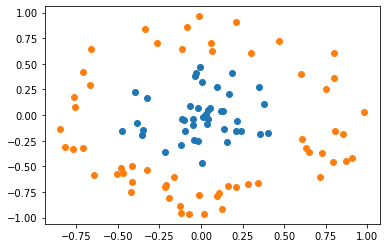

In [5]:

d = torch.utils.data.TensorDataset(X,Y)
train_loader = torch.utils.data.DataLoader(dataset=d, 
                                           batch_size=100, 
                                           shuffle=True)


x,y = iter(train_loader).next()
y1 = (y==1).view(-1)
y0 = (y==0).view(-1)
plt.scatter(x[y1,0], x[y1,1])
plt.scatter(x[y0,0], x[y0,1])
plt.show()

### Training

In [6]:
num_epochs = 1000
NN = Neural_Network()
for epoch in range(num_epochs):        
    if epoch%100==0:
        y_hat = NN.forward(X)
        print (f"#{epoch}, Loss: {- torch.mean(Y*torch.log(y_hat) + (1-Y)*torch.log(1 - y_hat)).detach().item()}")  # mean sum squared loss
        
    for i,(x, y) in enumerate(train_loader):
        NN.train(x, y)
        

#0, Loss: 0.8386861681938171
#100, Loss: 0.07891729474067688
#200, Loss: 0.052111998200416565
#300, Loss: 0.04177406430244446
#400, Loss: 0.034939974546432495
#500, Loss: 0.02946542017161846
#600, Loss: 0.024515490978956223
#700, Loss: 0.020199984312057495
#800, Loss: 0.01658220961689949
#900, Loss: 0.013716057874262333


### Testing

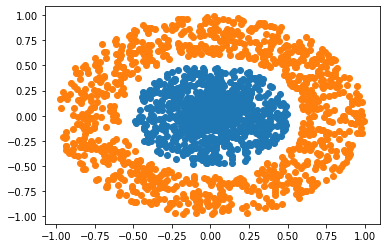

In [7]:
X_test, Y_test = generate_dataset(2000)
d = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(dataset=d, 
                                           batch_size=100, 
                                           shuffle=True)

x,y = iter(test_loader).next()

y_hat = NN.forward(X_test).round()
y1 = (y_hat==1).view(-1)
y0 = (y_hat==0).view(-1)
plt.scatter(X_test[y1,0], X_test[y1,1])
plt.scatter(X_test[y0,0], X_test[y0,1])
plt.show()

----------------------------------------------------------------
## Vanishing/Exploding Gradient

#### Problem:
As network goes deep, the gradients might become smaller and the weights are not being updated (no learning).

#### Immediate solutions:
1. Proper use of activation functions (try to avoid sigmoid)

2. better weights initialization

#### 1. Activations


<a href="https://drive.google.com/uc?export=view&id=1wRuSvWozr6DhkYwltPlEc9LK4u5zOl5i">
    <img src="https://drive.google.com/uc?export=view&id=1wRuSvWozr6DhkYwltPlEc9LK4u5zOl5i"
    style="width: 600px; max-width: 100%; height: auto"
    title="Click for the larger version." />
</a>
<br>
<br>
<a href="https://drive.google.com/uc?export=view&id=1NqK5Xsf6W7Wkz-ucznYowEWE1ZRRmA-L">
    <img src="https://drive.google.com/uc?export=view&id=1NqK5Xsf6W7Wkz-ucznYowEWE1ZRRmA-L"
    style="width: 400px; max-width: 100%; height: auto"
    title="Click for the larger version." />
</a>
<br>
<br>

<a href="https://drive.google.com/uc?export=view&id=15wb9BaAgwNUBvQ7CiiDhSWwVDMVzwDAr">
    <img src="https://drive.google.com/uc?export=view&id=15wb9BaAgwNUBvQ7CiiDhSWwVDMVzwDAr"
    style="width: 600px; max-width: 100%; height: auto"
    title="Click for the larger version." />
</a>

<br>
<br>
<a href="https://drive.google.com/uc?export=view&id=1Bj-e7JCazO4O_qOK_5lRiXIun-MgEjPd">
    <img src="https://drive.google.com/uc?export=view&id=1Bj-e7JCazO4O_qOK_5lRiXIun-MgEjPd"
    style="width: 1000px; max-width: 100%; height: auto"
    title="Click for the larger version." />
</a>



In [9]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
# MNIST Dataset (Images and Labels)

batch_size = 100
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transform,
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transform)

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [10]:
import torch.nn as nn
import numpy as np

class NeuralNet(nn.Module):
    """Simple class for non-linear fully connect network
    """
    def __init__(self, dims, act='ReLU'):
        super(NeuralNet, self).__init__()
        layers = []
        for i in range(len(dims)-2):
            in_dim = dims[i]
            out_dim = dims[i+1]

            layers.append(nn.Linear(in_dim, out_dim))
            if ''!=act:
                layers.append(getattr(nn, act)())

        layers.append(nn.Linear(dims[-2], dims[-1]))
        
        self.main = nn.Sequential(*layers)        
        #print(self.main)
        
    def forward(self, x):
        return self.main(x)

In [14]:
def train_k_deep_net(k, activation):

    net = NeuralNet([28*28]+[10 for _ in range(k)] + [10], activation)
    
    torch.manual_seed(1)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    second_layer_grads = []
    for epoch in range(1):
        for i,(x, y) in enumerate(train_loader):
            out = net(x.view(-1,28*28))
            loss = torch.nn.functional.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i%100==0:
                print(f'loss: {loss}')

            
            for j, p in enumerate(net.parameters()):
                if j == 2:
                    # return the norm of the gradient of the second layer
                    second_layer_grads.append(p.grad.clone()) 
                    break


    grads = torch.stack(second_layer_grads)
    return grads.norm(1, dim=(1,2)).mean()




norms_sigmoid = []
norms_relu = []

num_layers = list(range(1,8))
for i in num_layers:
    print(f'--------  num hidden layers: {i}  --------')
    print('Sigmoid:')
    norms_sigmoid.append(train_k_deep_net(i, 'Sigmoid'))
    
    print('relu:')
    norms_relu.append(train_k_deep_net(i, 'ReLU'))




--------  num hidden layers: 1  --------
Sigmoid:
loss: 2.3770885467529297
loss: 2.0327706336975098
loss: 1.6488415002822876
loss: 1.490828037261963
loss: 1.3431735038757324
loss: 1.168116807937622
relu:
loss: 2.3042564392089844
loss: 1.3107078075408936
loss: 0.6465412974357605
loss: 0.47838860750198364
loss: 0.43777620792388916
loss: 0.46565231680870056
--------  num hidden layers: 2  --------
Sigmoid:
loss: 2.328247308731079
loss: 2.2421908378601074
loss: 2.129669427871704
loss: 2.005331039428711
loss: 1.8276069164276123
loss: 1.6749930381774902
relu:
loss: 2.3082964420318604
loss: 1.4635415077209473
loss: 0.8200962543487549
loss: 0.5759565830230713
loss: 0.5381585359573364
loss: 0.5580353736877441
--------  num hidden layers: 3  --------
Sigmoid:
loss: 2.3740005493164062
loss: 2.3078343868255615
loss: 2.261384963989258
loss: 2.18552827835083
loss: 2.0496535301208496
loss: 1.867072582244873
relu:
loss: 2.3260416984558105
loss: 1.7739248275756836
loss: 0.9274449348449707
loss: 0.70928

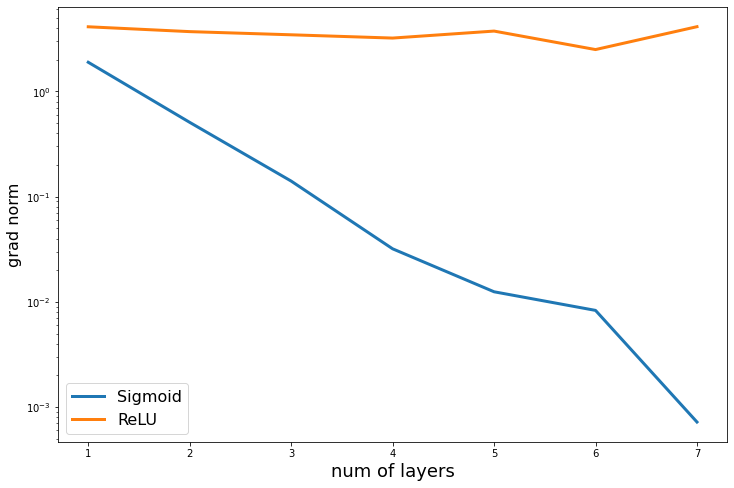

In [11]:
plt.figure(figsize=(12,8))
plt.plot(num_layers, norms_sigmoid, label="Sigmoid", linewidth=3)
plt.plot(num_layers, norms_relu,  label="ReLU", linewidth=3)


plt.legend(fontsize=16)
plt.xlabel('num of layers', fontsize=18)
plt.ylabel('grad norm', fontsize=16)
plt.yscale("log")

#### 2. Weights initialization
Here we compare two different weight initialization for a linear layer. 

$w_1 \sim \mathcal{U}(-1, 1)$ <br>
$w_2 \sim \mathcal{U}(-\sqrt{\frac{1}{k}}, \sqrt{\frac{1}{k}})$, where $k$ is the number of input features.

$w_2$ is the Pytorch default initialization and $w_1$ is a simple baseline.

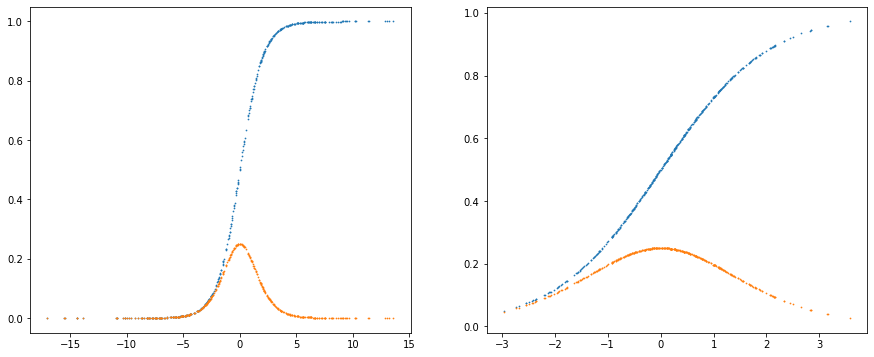

In [12]:
batch = 40
in_featurs = 20
out_features = 10

X = 2*torch.randn(batch,in_featurs)
W1 = torch.empty(in_featurs,out_features).uniform_(-1,1)
W2 = torch.empty(in_featurs,out_features).uniform_(-math.sqrt(1.0/in_featurs),math.sqrt(1.0/in_featurs))

z1 = torch.matmul(X,W1).view(-1)
z2 = torch.matmul(X,W2).view(-1)

fig,(ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

s1 = sigmoid(z1)
ax1.scatter(z1,s1, s=0.5)
ax1.scatter(z1,sigmoidPrime(s1), s=0.5)

s2 = sigmoid(z2)
ax2.scatter(z2, s2, s=0.5)
ax2.scatter(z2,sigmoidPrime(s2), s=0.5)